In [11]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import heapq
from io import StringIO

# ==============================================================================
# 1. DỮ LIỆU MỚI (ĐÃ CẬP NHẬT CẠNH 23-3 = 4)
# ==============================================================================
file_content = """IdStart	IdEnd	Length
0	19	50.0
0	4	50.7
1	20	23.5
2	1	26.5
3	20	33.8
4	7	49.3
5	6	39.8
6	7	50.0
7	8	48.1
7	23	45.0
8	22	51.9
9	10	25.4
10	24	19.1
11	12	22.9
12	13	29.0
13	14	44.5
14	15	26.5
15	18	100.0
16	9	109.0
17	11	77.2
18	2	200.0
19	21	50.0
19	5	60.2
20	0	50.0
21	16	46.5
22	18	100.0
23	3	4.0
24	22	100.0
24	17	100.0
"""

# Đọc dữ liệu
df = pd.read_csv(StringIO(file_content), sep='\t')
G = nx.from_pandas_edgelist(df, source='IdStart', target='IdEnd', edge_attr='Length')
for u, v in G.edges(): G[u][v]['weight'] = G[u][v]['Length']

# Tạo layout (Seed 42 thường ổn, nhưng bạn có thể đổi số khác nếu hình bị chồng chéo)
pos = nx.spring_layout(G, seed=30, k=0.5) # k=0.5 giúp các điểm giãn ra hơn

In [12]:
# ==============================================================================
# 2. HÀM VẼ CÓ MŨI TÊN (DIRECTED VISUALIZATION)
# ==============================================================================
def visualize_directed_flow(G, center_node, eps, pos):
    distances = {center_node: 0}
    queue = [(0, center_node)]
    
    # Lưu đường đi CÓ HƯỚNG: (từ_điểm, đến_điểm)
    path_edges = [] 
    reachable_nodes = []
    
    print(f"--- LUỒNG ĐI TỪ NODE {center_node} (Eps={eps}) ---")
    
    while queue:
        curr_dist, u = heapq.heappop(queue)
        
        if curr_dist > eps: continue
        
        if u != center_node:
            reachable_nodes.append(u)
            
        for v in G.neighbors(u):
            weight = G[u][v]['weight']
            new_dist = curr_dist + weight
            
            if new_dist <= eps:
                # Cập nhật đường đi
                if new_dist < distances.get(v, float('inf')):
                    distances[v] = new_dist
                    heapq.heappush(queue, (new_dist, v))
                    
                    # QUAN TRỌNG: Lưu hướng đi từ u -> v
                    path_edges.append((u, v))
                    print(f"  > Bước nhảy: {u} -> {v} (Cạnh: {weight}, Tổng: {new_dist})")

    # --- VẼ HÌNH ---
    plt.figure(figsize=(14, 10))
    
    # 1. Vẽ nền (Mờ)
    nx.draw_networkx_edges(G, pos, edge_color='#DDDDDD', width=1, arrows=False)
    # Vẽ nhãn trọng số cho tất cả cạnh (màu xám nhạt)
    all_weights = nx.get_edge_attributes(G, 'weight')
    # Làm tròn số cho đẹp
    all_weights = {k: f"{v:.1f}" for k, v in all_weights.items()}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=all_weights, font_color='#AAAAAA', font_size=8)

    # 2. Vẽ các điểm không chạm tới
    unreachable = [n for n in G.nodes() if n not in reachable_nodes and n != center_node]
    nx.draw_networkx_nodes(G, pos, nodelist=unreachable, node_color='lightgray', node_size=200, label='Ngoài vùng')

    # 3. Vẽ MŨI TÊN ĐƯỜNG ĐI (Màu đỏ)
    # arrows=True sẽ vẽ mũi tên chỉ hướng
    nx.draw_networkx_edges(G, pos, edgelist=path_edges, 
                           edge_color='red', width=2.5, 
                           arrows=True, arrowstyle='-|>', arrowsize=20,
                           label='Luồng đi (Flow)')

    # 4. Vẽ điểm trong vùng (Xanh) và Tâm (Vàng)
    if reachable_nodes:
        nx.draw_networkx_nodes(G, pos, nodelist=reachable_nodes, node_color='#90EE90', edgecolors='black', node_size=500, label='Hàng xóm')
    nx.draw_networkx_nodes(G, pos, nodelist=[center_node], node_color='yellow', edgecolors='red', linewidths=2, node_size=700, label='Tâm')

    # 5. Nhãn tên điểm
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')
    
    # 6. Tô đậm trọng số trên đường đi đỏ
    red_edge_labels = {edge: f"{G.edges[edge]['weight']:.1f}" for edge in path_edges}
    # Lưu ý: nx.draw_networkx_edge_labels mặc định nhận key là tuple (u,v) theo thứ tự nhỏ->lớn nếu là Graph vô hướng.
    # Để vẽ đúng, ta cần trick một chút hoặc chấp nhận nó đè lên label xám.
    # Ở đây vẽ đè lên màu đỏ cho rõ:
    nx.draw_networkx_edge_labels(G, pos, edge_labels=red_edge_labels, font_color='red', font_weight='bold', font_size=10)

    plt.title(f"MÔ PHỎNG LUỒNG ĐI CÓ HƯỚNG (DIRECTED FLOW)\nTâm: {center_node} | Eps: {eps}", fontsize=15)
    plt.legend(loc='upper right')
    plt.axis('off')
    plt.show()

--- LUỒNG ĐI TỪ NODE 0 (Eps=55.0) ---
  > Bước nhảy: 0 -> 19 (Cạnh: 50.0, Tổng: 50.0)
  > Bước nhảy: 0 -> 4 (Cạnh: 50.7, Tổng: 50.7)
  > Bước nhảy: 0 -> 20 (Cạnh: 50.0, Tổng: 50.0)


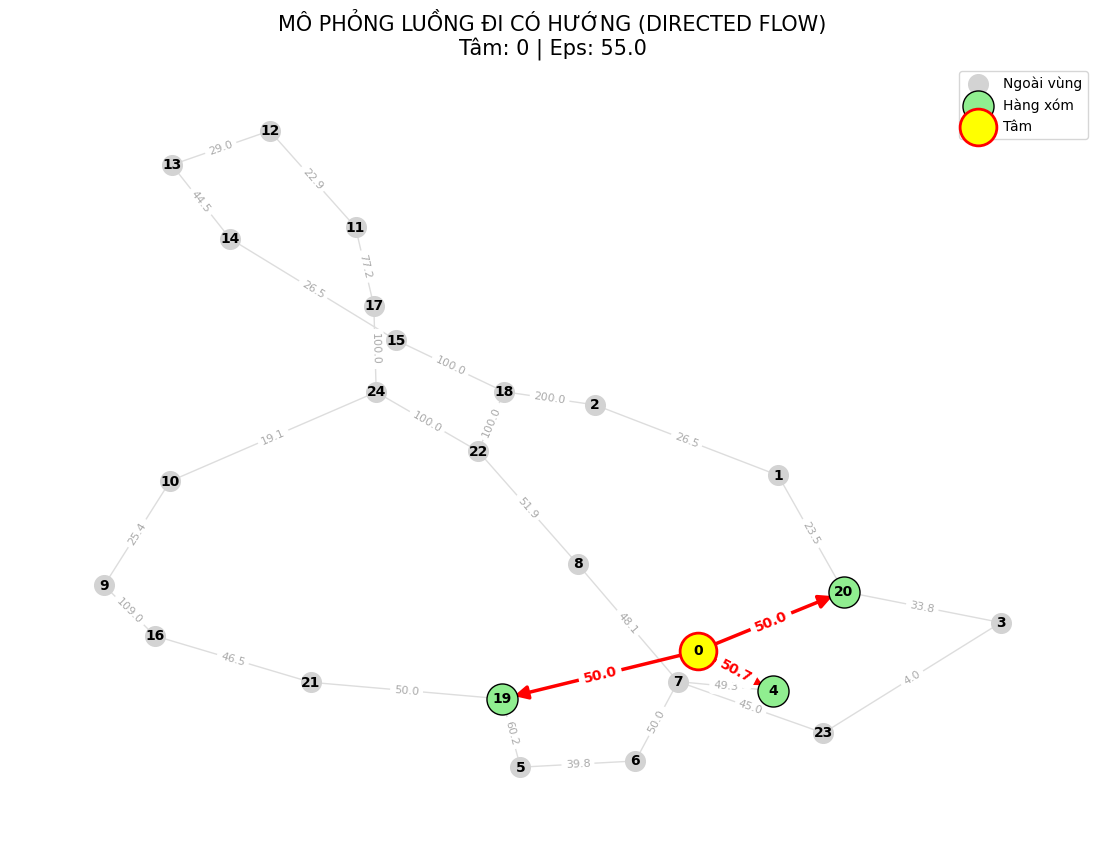

--- LUỒNG ĐI TỪ NODE 7 (Eps=50.0) ---
  > Bước nhảy: 7 -> 4 (Cạnh: 49.3, Tổng: 49.3)
  > Bước nhảy: 7 -> 6 (Cạnh: 50.0, Tổng: 50.0)
  > Bước nhảy: 7 -> 8 (Cạnh: 48.1, Tổng: 48.1)
  > Bước nhảy: 7 -> 23 (Cạnh: 45.0, Tổng: 45.0)
  > Bước nhảy: 23 -> 3 (Cạnh: 4.0, Tổng: 49.0)


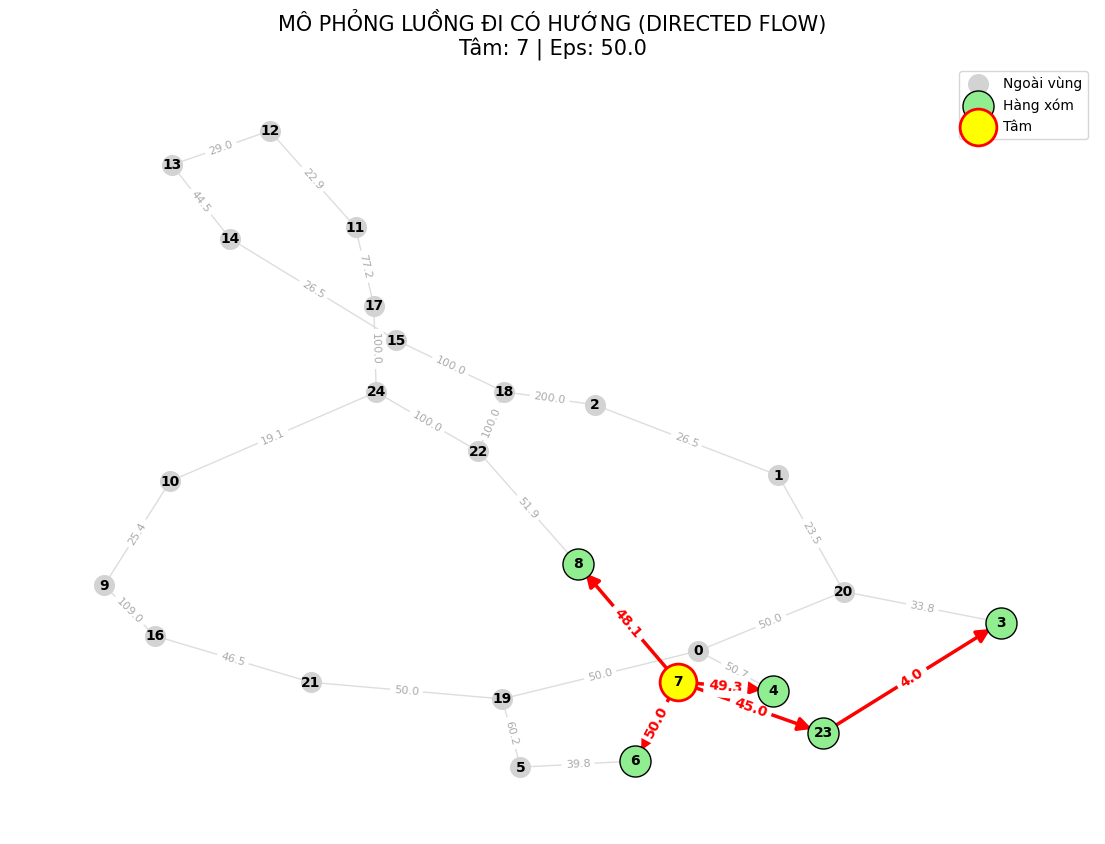

In [13]:
# ==============================================================================
# PHẦN 3: CHẠY THỬ NGHIỆM
# ==============================================================================

# Kịch bản 1: Đứng ở Node 0, tìm các điểm trong bán kính 55m
# Node 0 nối với 19 (50m) và 4 (50.7m). Cả hai đều <= 55 nên sẽ màu Xanh.
# Node 20 cũng nối với 0 (50m) nên cũng Xanh.
visualize_directed_flow(G, center_node=0, eps=55.0, pos=pos)

# Kịch bản 2: Đứng ở Node 7, tìm các điểm trong bán kính 50m
# Node 7 là một ngã tư lớn nối với 4, 6, 8, 23. Tất cả đều gần nhau.
visualize_directed_flow(G, center_node=7, eps=50.0, pos=pos)